In [101]:
# Creating Population Change Pyramid by Country from 2000-2050

"Population Change Pyramid by Country" showing how the change in total population evolves over time (2000 to 2050). Each year, we’ll display countries ranked by how much their population has changed relative to a base year (2020).

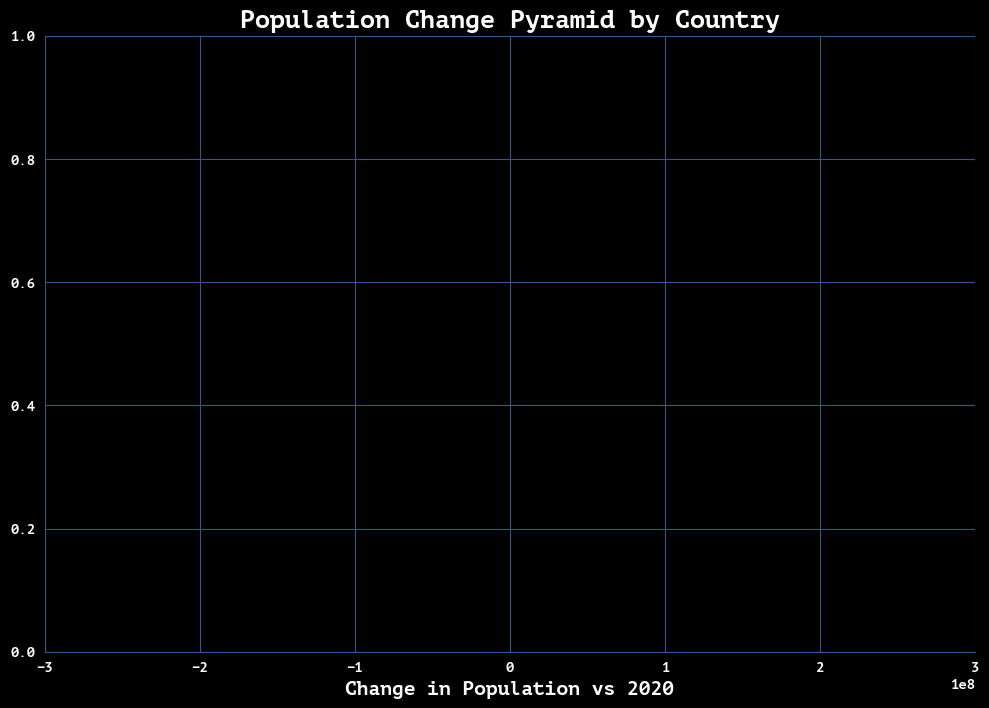

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Load population data
df = pd.read_csv("../data/processed/pop_total_clean.csv")

# Choose base year to compare against
base_year = 2020
top_n = 10  # Number of countries to show per frame

# Create pivot table: rows = ISO3, columns = Year
pivot = df.pivot_table(index=["ISO3", "Country"], columns="Year", values="Population")

# Calculate population change vs base year
pop_change = pivot.subtract(pivot[base_year], axis=0)

# Reset index to melt
pop_change = pop_change.reset_index().melt(id_vars=["ISO3", "Country"], var_name="Year", value_name="PopChange")
pop_change["Year"] = pop_change["Year"].astype(int)

# For animation: list of years
years = sorted(pop_change["Year"].unique())

# Set up figure
fig, ax = plt.subplots(figsize=(12, 8))
fig.patch.set_facecolor('black')
ax.set_facecolor('black')
ax.tick_params(colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.title.set_color('white')

bars = ax.barh([], [])

year_text = ax.text(0.95, 0.9, '', transform=ax.transAxes,
                    fontsize=18, ha='right', color='white')

def init():
    ax.clear()
    ax.set_facecolor('black')
    ax.tick_params(colors='white')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')
    ax.set_xlim(-300_000_000, 300_000_000)  # Adjust as needed
    ax.set_xlabel("Change in Population vs 2020", fontsize=14)
    ax.set_title("Population Change Pyramid by Country", fontsize=18)
    return bars

def animate(i):
    year = years[i]
    data_year = pop_change[pop_change["Year"] == year].sort_values("PopChange")

    # Get top N positive and negative changes
    data_top = pd.concat([data_year.head(top_n), data_year.tail(top_n)])
    data_top = data_top.sort_values("PopChange")

    ax.clear()
    ax.barh(data_top["Country"], data_top["PopChange"], 
            color=data_top["PopChange"].apply(lambda x: 'green' if x > 0 else 'red'))
    
    ax.set_title(f"Population Change from {base_year} — Year: {year}", fontsize=18)
    ax.set_xlabel("Change in Population", fontsize=14)
    ax.set_xlim(-300_000_000, 300_000_000)  # Set based on your data
    ax.tick_params(colors='white')
    ax.set_facecolor('black')
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    ax.title.set_color('white')

    return ax.patches

ani = animation.FuncAnimation(
    fig, animate, frames=len(years), init_func=init,
    interval=300, blit=False, repeat=False
)

from IPython.display import HTML
HTML(ani.to_jshtml())




In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Load data
female_data = pd.read_csv("../data/raw/population_ratio_female.csv")
male_data = pd.read_csv("../data/raw/population_ratio_male.csv")

country_code = "JPN"

# Filter by country
female_data = female_data[female_data["country_code"] == country_code]
male_data = male_data[male_data["country_code"] == country_code]

# Melt to long format
female_long = female_data.melt(
    id_vars=['country_name', 'country_code', 'indicator_name', 'indicator_code'],
    var_name='year',
    value_name='population'
)
male_long = male_data.melt(
    id_vars=['country_name', 'country_code', 'indicator_name', 'indicator_code'],
    var_name='year',
    value_name='population'
)

# Extract age group from indicator_name (assuming format like "Population ratio female age 00-04")
female_long['age_group'] = female_long['indicator_name']
male_long['age_group'] = male_long['indicator_name']


# Convert year to int
female_long['year'] = female_long['year'].astype(int)
male_long['year'] = male_long['year'].astype(int)


In [104]:
def age_sort_key(age):
    if pd.isna(age):
        return 9999  # push NaN to the end if any
    age = str(age)
    if '+' in age:
        return int(age.replace('+', '')) * 10
    else:
        return int(age.split('-')[0])

age_order = sorted(female_long['age_group'].dropna().unique(), key=age_sort_key)


In [105]:
female_long['year'] = female_long['year'].astype(int)
male_long['year'] = male_long['year'].astype(int)


In [106]:
base_year = 1960

# Merge female and male data (optional, you can plot separately)
# Here we'll prepare data for both genders individually

# Create pivot tables: rows = age_group, columns = year, values = population
female_pivot = female_long.pivot_table(index='age_group', columns='year', values='population', aggfunc='sum')
male_pivot = male_long.pivot_table(index='age_group', columns='year', values='population', aggfunc='sum')


# Calculate change from base year
female_change = female_pivot.subtract(female_pivot[base_year], axis=0)
male_change = male_pivot.subtract(male_pivot[base_year], axis=0)


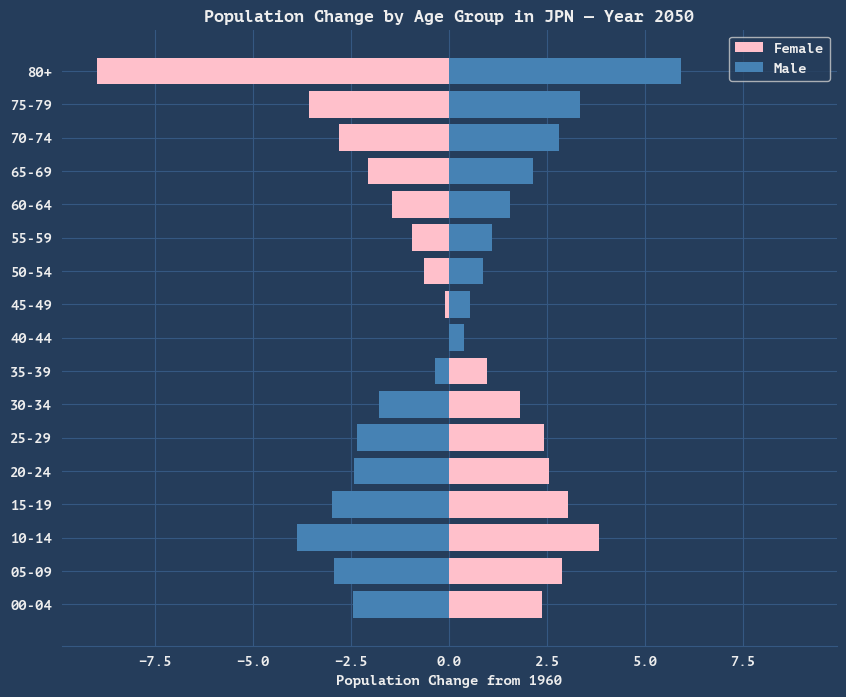

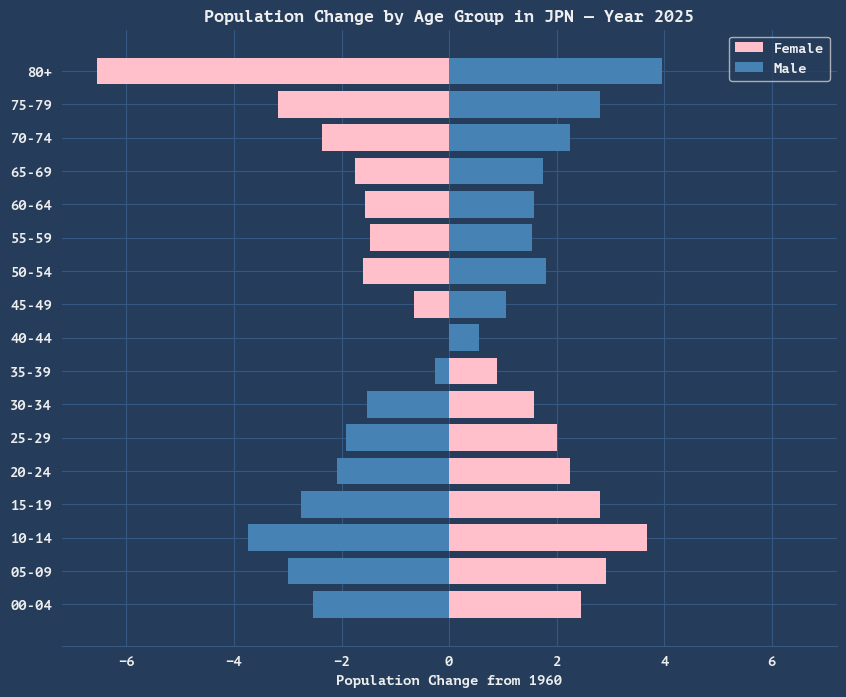

In [107]:
fig, ax = plt.subplots(figsize=(10, 8))

years = list(range(base_year, 2051, 5))

def animate(year):
    ax.clear()
    
    f = female_change[year].reindex(age_order)
    m = male_change[year].reindex(age_order)
    
    max_val = max(abs(f).max(), abs(m).max())
    if max_val == 0:
        max_val = 1  # fallback to avoid identical limits
    
    ax.barh(age_order, -f, color='pink', label='Female')
    ax.barh(age_order, m, color='steelblue', label='Male')
    
    ax.set_xlim(-max_val * 1.1, max_val * 1.1)
    ax.set_xlabel('Population Change from 1960')
    ax.set_title(f'Population Change by Age Group in {country_code} — Year {year}')
    ax.legend()
    ax.grid(True, axis='x')


ani = animation.FuncAnimation(fig, animate, frames=years, interval=1000, repeat=False)

from IPython.display import HTML
HTML(ani.to_jshtml())


# Plot static chart for 2025
fig_static, ax_static = plt.subplots(figsize=(10, 8))

year_static = 2025

f_static = female_change[year_static].reindex(age_order)
m_static = male_change[year_static].reindex(age_order)

max_val_static = max(abs(f_static).max(), abs(m_static).max())
if max_val_static == 0:
    max_val_static = 1

ax_static.barh(age_order, -f_static, color='pink', label='Female')
ax_static.barh(age_order, m_static, color='steelblue', label='Male')

ax_static.set_xlim(-max_val_static * 1.1, max_val_static * 1.1)
ax_static.set_xlabel('Population Change from 1960')
ax_static.set_title(f'Population Change by Age Group in {country_code} — Year {year_static}')
ax_static.legend()
ax_static.grid(True, axis='x')

plt.show()

